<a href="https://colab.research.google.com/github/takeru0208/sample_deep_learning/blob/feature/sample_neuralnet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this program

this program is quoted by [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
print(trainset)
print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


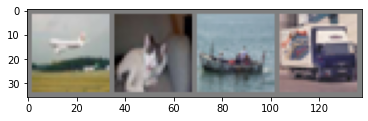

plane     cat    ship   truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    


dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('   '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# __init__のpoolとforwardのpoolは何が違うんだ、__init__にて学習する重みがある処理を行っているのかな

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [5]:

params = list(net.parameters())
#print model's parameters with its name and size 

for name, param in net.named_parameters():
    if param.requires_grad:
      print(name)
      print(param.size())

conv1.weight
torch.Size([6, 3, 5, 5])
conv1.bias
torch.Size([6])
conv2.weight
torch.Size([16, 6, 5, 5])
conv2.bias
torch.Size([16])
fc1.weight
torch.Size([120, 400])
fc1.bias
torch.Size([120])
fc2.weight
torch.Size([84, 120])
fc2.bias
torch.Size([84])
fc3.weight
torch.Size([10, 84])
fc3.bias
torch.Size([10])


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss /2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.183
[1,  4000] loss: 1.870
[1,  6000] loss: 1.651
[1,  8000] loss: 1.562
[1, 10000] loss: 1.516
[1, 12000] loss: 1.455
[2,  2000] loss: 1.395
[2,  4000] loss: 1.369
[2,  6000] loss: 1.360
[2,  8000] loss: 1.318
[2, 10000] loss: 1.349
[2, 12000] loss: 1.282
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

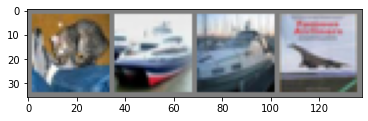

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct /total))

Accuracy of the network on the 10000 test images: 54 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100*class_correct[i] / class_total[i]))
              

Accuracy of plane : 59 %
Accuracy of   car : 56 %
Accuracy of  bird : 54 %
Accuracy of   cat : 38 %
Accuracy of  deer : 48 %
Accuracy of   dog : 46 %
Accuracy of  frog : 56 %
Accuracy of horse : 49 %
Accuracy of  ship : 67 %
Accuracy of truck : 71 %


In [29]:
x = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)
out = x.pow(2)
print(x)
print(out)
print(out.sum())
out.sum().backward()
print(x.grad)
# out.backward()
# print(x.grad)

tensor([[ 1., -1.],
        [ 1.,  1.]], requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], grad_fn=<PowBackward0>)
tensor(4., grad_fn=<SumBackward0>)
tensor([[ 2., -2.],
        [ 2.,  2.]])
